In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder

import sklearn
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

C:\Users\User\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.23.1


Python 3.6.5 :: Anaconda, Inc.


### data

In [3]:
#데이터로드
path = './data/'
data = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [4]:
data.shape, submission.shape

((24697792, 12), (1394, 5))

### 전처리

#### 결측처리

In [5]:
# 시군구 결측은 모두 세종
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

### 추가변수

#### 18 사업체총조사

In [6]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [7]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [8]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [9]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 추가변수 결합

In [10]:
data.shape

(24697792, 12)

In [11]:
grouped = pd.merge(data,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')

In [12]:
grouped.shape

(24697792, 16)

In [13]:
grouped.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,company,employee,LP,JP
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,263.0,399.0,0.138432,0.279221


### 인코딩

#### 날짜변환

In [20]:
grouped['year'] = grouped['REG_YYMM'].apply(lambda x : int(str(x)[:4]))
grouped['month'] = grouped['REG_YYMM'].apply(lambda x : int(str(x)[4:]))
data.drop(['REG_YYMM'],axis= 1,inplace = True)

In [14]:
#인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
for column in encoders.keys():
    encoder = encoders[column]
    grouped[column] = encoder.transform(grouped[column])

In [26]:
grouped.drop(['REG_YYMM'],axis= 1,inplace = True)

### Model Tuning & Evaluation

In [28]:
#2019.12까지 데이터로 20.03을 예측
train_set = grouped[grouped.year == 2019]
eval_set = grouped[(grouped.year == 2020)&(grouped.month == 3)]

In [29]:
params = {'random_state': 42,
          'learning_rate': 0.01,
          'max_depth': 8,
          'num_leaves': 64,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7}

In [30]:
grouped

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,company,employee,LP,JP,year,month
0,0,3,0,0,3,1,1,1,4,311200,4,263.0,399.0,0.138432,0.279221,2019,1
1,0,3,0,0,3,2,1,2,7,1374500,8,263.0,399.0,0.138432,0.279221,2019,1
2,0,3,0,0,3,2,2,2,6,818700,6,263.0,399.0,0.138432,0.279221,2019,1
3,0,3,0,0,3,3,1,3,4,1717000,5,263.0,399.0,0.138432,0.279221,2019,1
4,0,3,0,0,3,3,1,4,3,1047300,3,263.0,399.0,0.138432,0.279221,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,16,202,40,16,202,2,1,2,3,43300,4,11.0,492.0,0.004484,0.010694,2020,3
24697788,16,202,40,16,202,3,1,3,3,35000,3,11.0,492.0,0.004484,0.010694,2020,3
24697789,16,202,40,16,202,4,1,4,4,188000,6,11.0,492.0,0.004484,0.010694,2020,3
24697790,16,202,40,16,202,4,2,4,4,99000,6,11.0,492.0,0.004484,0.010694,2020,3


In [31]:
#eval, train 구성
train_x = train_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
train_y = np.log1p(train_set['AMT'])

eval_x = eval_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
eval_y = np.log1p(eval_set['AMT'])

categorical_features = ['CARD_SIDO_NM','CARD_CCG_NM','HOM_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','SEX_CTGO_CD','AGE','FLC']

train_ds = lgb.Dataset(train_x,label=train_y,free_raw_data=False,
                       categorical_feature=categorical_features)
eval_ds = lgb.Dataset(eval_x,label=eval_y,free_raw_data=False,
                      categorical_feature=categorical_features)

In [32]:
evaluation_results ={}
model = lgb.train(params,train_ds,
                  num_boost_round=10000,
                  valid_sets=[train_ds, eval_ds],
                  valid_names=['Train', 'Eval'],
                  verbose_eval=500,
                  early_stopping_rounds=100, evals_result = evaluation_results)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[500]	Train's rmse: 1.30366	Eval's rmse: 1.33924
[1000]	Train's rmse: 1.16127	Eval's rmse: 1.19705
[1500]	Train's rmse: 1.07158	Eval's rmse: 1.10687
[2000]	Train's rmse: 1.00444	Eval's rmse: 1.04016
[2500]	Train's rmse: 0.956931	Eval's rmse: 0.993379
[3000]	Train's rmse: 0.922251	Eval's rmse: 0.960095
[3500]	Train's rmse: 0.894309	Eval's rmse: 0.933267
[4000]	Train's rmse: 0.870242	Eval's rmse: 0.91008
[4500]	Train's rmse: 0.850424	Eval's rmse: 0.891338
[5000]	Train's rmse: 0.832749	Eval's rmse: 0.875023
[5500]	Train's rmse: 0.816227	Eval's rmse: 0.86018
[6000]	Train's rmse: 0.803741	Eval's rmse: 0.848965
[6500]	Train's rmse: 0.793353	Eval's rmse: 0.839621
[7000]	Train's rmse: 0.783778	Eval's rmse: 0.831331
[7500]	Train's rmse: 0.775322	Eval's rmse: 0.823916
[8000]	Train's rmse: 0.767939	Eval's rmse: 0.817762
[8500]	Train's rmse: 0.761318	Eval's rmse: 0.812288
[9000]	Train's rmse: 0.755359	Eval's rmse: 0.807496
[9500]	Train'

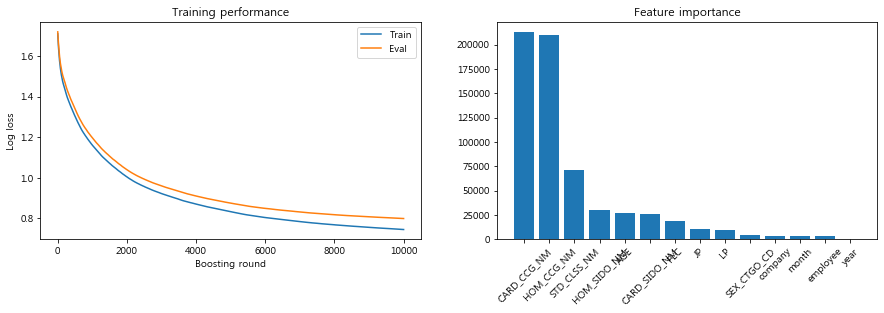

In [33]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['rmse'], label='Train')
axs[0].plot(evaluation_results['Eval']['rmse'], label='Eval')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': model.feature_name(), 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'],rotation=45)
axs[1].set_title('Feature importance')

plt.show()

In [35]:
grouped

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,company,employee,LP,JP,year,month
0,0,3,0,0,3,1,1,1,4,311200,4,263.0,399.0,0.138432,0.279221,2019,1
1,0,3,0,0,3,2,1,2,7,1374500,8,263.0,399.0,0.138432,0.279221,2019,1
2,0,3,0,0,3,2,2,2,6,818700,6,263.0,399.0,0.138432,0.279221,2019,1
3,0,3,0,0,3,3,1,3,4,1717000,5,263.0,399.0,0.138432,0.279221,2019,1
4,0,3,0,0,3,3,1,4,3,1047300,3,263.0,399.0,0.138432,0.279221,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,16,202,40,16,202,2,1,2,3,43300,4,11.0,492.0,0.004484,0.010694,2020,3
24697788,16,202,40,16,202,3,1,3,3,35000,3,11.0,492.0,0.004484,0.010694,2020,3
24697789,16,202,40,16,202,4,1,4,4,188000,6,11.0,492.0,0.004484,0.010694,2020,3
24697790,16,202,40,16,202,4,2,4,4,99000,6,11.0,492.0,0.004484,0.010694,2020,3


In [ ]:
#예측 탬플릿 만들기
CARD_SIDO_NMs = grouped['CARD_SIDO_NM'].unique()
CARD_CCG_NMs = grouped['CARD_CCG_NM'].unique()
STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
HOM_CCG_NMs = grouped['HOM_CCG_NM'].unique()
AGEs = grouped['AGE'].unique()
SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
FLCs = grouped['FLC'].unique()
years = [2020]
months = [3]

temp = []
for CARD_SIDO_NM in tqdm(CARD_SIDO_NMs):
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for HOM_SIDO_NM in HOM_SIDO_NMs:
                for HOM_CCG_NM in HOM_CCG_NMs:
                    for AGE in AGEs:
                        for SEX_CTGO_CD in SEX_CTGO_CDs:
                            for FLC in FLCs:
                                for year in years:
                                    for month in months:
                                        temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns = train_x.columns[:-2])

In [ ]:
temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'outer')

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']
temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
temp['CARD_SIDO_NM'] = temp['CARD_SIDO_NM'].astype(int)
temp['STD_CLSS_NM'] = temp['STD_CLSS_NM'].astype(int)

In [ ]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
#정답
eval_set['REG_YYMM'] = eval_set['year']*100 +eval_set['month']
eval_set = eval_set[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
eval_set_answer = eval_set.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
# 디코딩
eval_set_answer['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(eval_set_answer['CARD_SIDO_NM'])
eval_set_answer['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(eval_set_answer['STD_CLSS_NM'])

In [ ]:
eval_set_answer.columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT_answer']

In [ ]:
temp = pd.merge(temp,eval_set_answer,how = 'left')

In [ ]:
#강원 정기 항공 운송업,면세점은 데이터로 보유하고 있지 않음. 근데 높게 예측 
temp.loc[temp.AMT_answer.isna()]
# temp.loc[temp.AMT_answer.isna()].to_csv('./insight/없는없종na로라도 넣어봄.csv')

### predict

In [ ]:
#train to private
one = grouped[grouped.year == 2019]
two = grouped[(grouped.year == 2020)&(grouped.month == 1)]

p_train = pd.concat([one,two])

In [ ]:
# Feature, taget 설정
train_features = p_train.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
train_target = np.log1p(p_train['AMT'])

In [ ]:
train_ds = lgb.Dataset(train_features,label=train_target)
model = lgb.train(params,train_ds,num_boost_round=1000)

In [32]:
#예측 탬플릿 만들기
CARD_SIDO_NMs = grouped['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
AGEs = grouped['AGE'].unique()
SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
FLCs = grouped['FLC'].unique()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in tqdm(CARD_SIDO_NMs):
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns = train_features.columns[:-2])

In [33]:
temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [34]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']
temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [35]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [36]:
#제출파일
submission = pd.read_csv('data/submission.csv',index_col=0)
submission = submission.drop(['AMT'],axis= 1)
submission = submission.merge(temp, left_on=['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],right_on =['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
submission.index.name = 'id'